# Hamiltonian Variational Auto-Encoder

[Anthony L Caterini, Arnaud Doucet, and Dino Sejdinovic. “Hamiltonian Variational AutoEncoder”](https://arxiv.org/pdf/1805.11328.pdf)

[Markov Chain Monte Carlo and Variational Inference:
Bridging the Gap](https://arxiv.org/pdf/1805.11328.pdf)

[Variational Inference with Normalizing Flows](https://arxiv.org/pdf/1505.05770.pdf)

In [1]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
from tqdm.notebook import tqdm
import math
from torchsummary import summary
from typing import Callable, Tuple, Union, List
import os
import sys
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
N_WORKERS = 4 if os.name != 'nt' else 0
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    DEVICE = torch.device('cpu')
    IS_CUDA = False
    
print("Device:", DEVICE)

Device: cuda


In [3]:
def sum_keep(x: torch.Tensor, dims: List[int]=[]):
    x_dims = set(range(len(x.shape)))
    dims = list(x_dims - set(dims))
    if len(dims) > 0:
        return x.sum(dims)
    else:
        return x

In [4]:
class Prior(nn.Module):
    def __init__(self):
        """
        Prior distribution q(*) on R^l 
        """
        super().__init__()
    
    def sample(self) -> torch.Tensor:
        """
        Return batch of samples from the prior,
        optionally conditioned on x
        """
        raise NotImplementedError
    
    def log_prob(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute log probability of q(z)
        """
        raise NotImplementedError

In [5]:
class NormalPrior(Prior):
    def __init__(self, loc: torch.Tensor, log_scale: torch.Tensor):
        """
        Prior normal distribution of batch 
        """
        super().__init__()
        self.dim = loc.shape[-1]
        self.loc = loc
        self.log_scale = log_scale
    
    def sample(self, n_samples: int=1) -> torch.Tensor:
        """
        Return batch of samples from the prior,
        optionally conditioned on x
        """
        new_shape = list(self.loc.shape)
        new_shape.insert(1, n_samples)
        
        samples = (
                self.loc[:, None, :]
                + self.log_scale.exp()[:, None, :] * torch.randn(*new_shape,
                                                                 device=self.loc.device)
        )
        return samples.squeeze(1)
        
        
    def log_prob(self, z: torch.Tensor, keep: Union[int, List[int]]=[]) -> torch.Tensor:
        """
        Compute log probability of q(z)
        """
        if len(z.shape) == 3:
            log_scale = self.log_scale[:, None, :]
            loc = self.loc[:, None, :]
        else:
            log_scale = self.log_scale
            loc = self.loc
        
        return sum_keep(
            - log_scale
            - 0.5*math.log(2*math.pi)
            - 0.5*(z - loc)**2/log_scale.exp()**2, keep)

In [6]:
class EncoderPrior(Prior):
    def __init__(self, x: torch.Tensor, encoder: nn.Module):
        """
        Prior distribution q(*) on R^l
        """
        super().__init__()
        self.x = x
        self.encoder = encoder
        
        loc, log_scale = self.encoder(x)
        self.prior = NormalPrior(loc, log_scale)
    
    def sample(self, n_samples: int=1) -> torch.Tensor:
        """
        Return batch of samples from the prior,
        optionally conditioned on x
        """
        return self.prior.sample(n_samples)
    
    def log_prob(self, z: torch.Tensor, keep: Union[int, List[int]]=[]) -> torch.Tensor:
        """
        Compute log probability of q(z)
        """
        return self.prior.log_prob(z, keep)

In [7]:
class Posterior(nn.Module):
    def __init__(self):
        """
        Posterior distribution p(x, *) on an arbitrary space 
        """
        super().__init__()
    
    def log_prob(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute log probability of p(x, z)
        """
        raise NotImplementedError

In [8]:
class BernoulliPosterior(Posterior):
    def __init__(self, x: torch.Tensor):
        """
        Posterior distribution p(x, *) on an arbitrary space 
        """
        super().__init__()
        self.x = x
        self.loss = nn.BCELoss(reduction="none")
    
    def log_prob(self, z: torch.Tensor, keep: Union[int, List[int]]=[]) -> torch.Tensor:
        """
        Compute log probability of p(x, z)
        """
        # (B, N, C, H, W)
        if len(z.shape) == 5:
            x = self.x[:, None, ...]
        else:
            x = self.x
        z, x = torch.broadcast_tensors(z, x)
      
        return sum_keep(-self.loss(z, x), keep)

In [9]:
class DecoderPosterior(Posterior):
    def __init__(self, x: torch.Tensor, decoder: nn.Module):
        """
        Posterior distribution p(x, *) on an arbitrary space 
        """
        super().__init__()
        self.x = x
        self.decoder = decoder
        self.bernoulli = BernoulliPosterior(x)
    
    def log_prob(self, z: torch.Tensor, keep: Union[int, List[int]]=[]) -> torch.Tensor:
        """
        Compute log probability of p(x, z):
        z ~ N (0, I),
        x ~ Bernoulli (x | decoder(z))
        """
        log_prob_prior = - 0.5*(math.log(2*math.pi) + z**2)
        
        old_shape = list(z.shape)
        if len(old_shape) == 3:
            new_shape = (old_shape[0]*old_shape[1], *old_shape[2:])
            z = z.reshape(new_shape)
            
        out = self.decoder(z)
        
        if len(old_shape) == 3:
            out = out.reshape(*old_shape[:2], *out.shape[1:])
         
        return self.bernoulli.log_prob(out, keep) + sum_keep(log_prob_prior, keep)

In [10]:
class HIS(nn.Module):
    def __init__(self, dim: int, K: int=15, 
                 eps_init: float=5e-3, eps_max: float=0.5,
                 verbose: bool=False
                ):
        """
        Initializes Hamiltonian Importance Sampling
        dim -- latent space dimension 
        K   -- number of MC steps
        """
        super().__init__()
        self.K = K
        self.dim = dim
        self.eps_init = eps_init
        self.eps_max = eps_max
        self.verbose = verbose
        
        init_logit_eps = -torch.log(eps_max / eps_init  * torch.ones(dim) - 1)
        self.logit_eps = nn.Parameter(init_logit_eps)
        self.log_alpha = nn.Parameter(torch.zeros(K))

        self.hist = []
        
    def _get_grad(self, x: torch.Tensor, f: Callable) -> torch.Tensor:
        y = x.clone().detach().requires_grad_(True) # grad is empty
        f(y).backward()
        return y.grad.detach()
        
    def elbo(self, prior: Prior, posterior: Posterior) -> torch.Tensor:
        # keep alpha < 1
        with torch.no_grad():
            sampler.log_alpha.clamp_(max=0.)
        
        eps = self.eps_max * torch.sigmoid(self.logit_eps)
        alphas = self.log_alpha.exp()
        log_beta_0_sqrt = self.log_alpha.sum() 
        beta_0_sqrt = log_beta_0_sqrt.exp()
        
        
        z = prior.sample()
        rho = torch.randn_like(z)/beta_0_sqrt

        rho = torch.zeros_like(z)
        log_rho_prior = -self.dim/2
        log_q_bar = prior.log_prob(z) + log_rho_prior
        
        self.hist = []
        for k in range(self.K):
            if self.verbose:
                print(f"[HIS] MC sample {k}")
            # Leap-frog
            rho = rho + 0.5*eps * self._get_grad(z, posterior.log_prob) # + as log likelihood, not nll
            z = z + eps * rho
            if self.verbose:
                self.hist.append(z.detach().clone().cpu())
            rho = rho + 0.5*eps * self._get_grad(z, posterior.log_prob) # + as log likelihood, not nll
            
            # Tempering
            rho = rho * alphas[k]
        
        log_rho_posterior = -0.5*torch.sum(rho**2)
        log_p_bar = posterior.log_prob(z) + log_rho_posterior
        
        return log_p_bar - log_q_bar

In [11]:
class IWAE(nn.Module):
    def __init__(self, K: int=15, reduction: str="sum"):
        """
        Initializes Hamiltonian Importance Sampling
        dim -- latent space dimension 
        K   -- number of importance samples
        """
        super().__init__()
        self.K = K
        self.reduction = reduction
        
    def elbo(self, prior: Prior, posterior: Posterior) -> torch.Tensor:
        z = prior.sample(self.K)
        
        total = (
            posterior.log_prob(z, keep=[0, 1]) 
            - prior.log_prob(z, keep=[0, 1])
        )
        log_lik = torch.logsumexp(total, dim=1) - math.log(self.K)
        
        if self.reduction == "sum":
            return log_lik.sum()
        elif self.reduction == "none":
            return log_lik
        else:
            raise NotImplementedError

In [12]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.reshape(*self.shape)

In [13]:
class ImageEncoder(nn.Module):
    def __init__(self, z_dim: int):
        super().__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(
            
                nn.BatchNorm2d(1),
                nn.Conv2d(1, 16, 5, 2, 2), # 28 -> 14 
                nn.Softplus(),
                nn.BatchNorm2d(16),
            
                nn.Conv2d(16, 32, 5, 2, 2), # 14 -> 7
                nn.Softplus(),
            
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, 5, 2, 2), # 7 -> 4
            
                nn.BatchNorm2d(32),
                Reshape(-1, 32*4*4),
                nn.Linear(32*4*4, 450),
                nn.Softplus(),
                nn.BatchNorm1d(450),
                nn.Linear(450, 2*z_dim)
            )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.model(x)
        loc, log_scale = out[:, :self.z_dim], out[:, self.z_dim:]
        return loc, log_scale

In [14]:
class ImageDecoder(nn.Module):
    def __init__(self, z_dim: int):
        super().__init__()
        self.z_dim = z_dim
        self.model = nn.Sequential(
                nn.BatchNorm1d(z_dim),
                nn.Linear(z_dim, 450),
                nn.Softplus(),
                nn.BatchNorm1d(450),
                nn.Linear(450, 32*4*4),
                nn.Softplus(),
                Reshape(-1, 32, 4, 4),
            
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, 5, 1, 2), 
                nn.UpsamplingNearest2d(size=7), # 4 -> 7
                nn.Softplus(),
            
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 16, 5, 1, 2),
                nn.UpsamplingNearest2d(size=14), # 7 -> 14
                nn.Softplus(),
            
                nn.BatchNorm2d(16),
                nn.Conv2d(16, 16, 5, 1, 2),
                nn.UpsamplingNearest2d(size=28), # 14 -> 28
                nn.Softplus(),

                nn.Conv2d(16, 1, 5, 1, 2),
                nn.Sigmoid()
            )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [15]:
encoder = ImageEncoder(z_dim=64).to("cuda")
summary(encoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 28, 28]               2
            Conv2d-2           [-1, 16, 14, 14]             416
          Softplus-3           [-1, 16, 14, 14]               0
       BatchNorm2d-4           [-1, 16, 14, 14]              32
            Conv2d-5             [-1, 32, 7, 7]          12,832
          Softplus-6             [-1, 32, 7, 7]               0
       BatchNorm2d-7             [-1, 32, 7, 7]              64
            Conv2d-8             [-1, 32, 4, 4]          25,632
       BatchNorm2d-9             [-1, 32, 4, 4]              64
          Reshape-10                  [-1, 512]               0
           Linear-11                  [-1, 450]         230,850
         Softplus-12                  [-1, 450]               0
      BatchNorm1d-13                  [-1, 450]             900
           Linear-14                  [

In [16]:
decoder = ImageDecoder(z_dim=64).to("cuda")
summary(decoder, (64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                   [-1, 64]             128
            Linear-2                  [-1, 450]          29,250
          Softplus-3                  [-1, 450]               0
       BatchNorm1d-4                  [-1, 450]             900
            Linear-5                  [-1, 512]         230,912
          Softplus-6                  [-1, 512]               0
           Reshape-7             [-1, 32, 4, 4]               0
       BatchNorm2d-8             [-1, 32, 4, 4]              64
            Conv2d-9             [-1, 32, 4, 4]          25,632
UpsamplingNearest2d-10             [-1, 32, 7, 7]               0
         Softplus-11             [-1, 32, 7, 7]               0
      BatchNorm2d-12             [-1, 32, 7, 7]              64
           Conv2d-13             [-1, 16, 7, 7]          12,816
UpsamplingNearest2d-14           [-1,

In [17]:
BATCH_SIZE = 256

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.round()
])

data_train = MNIST('data/mnist', download=True, transform=transform, train=True)
data_val   = MNIST('data/mnist', download=True, transform=transform, train=False)

loader_train = DataLoader(Subset(data_train, torch.arange(10_000)), 
                         batch_size=BATCH_SIZE, shuffle=True,
                         pin_memory=IS_CUDA)
loader_val   = DataLoader(Subset(data_val, torch.arange(1_000)), 
                         batch_size=BATCH_SIZE, shuffle=False,
                         pin_memory=IS_CUDA)

In [19]:
n_epochs = 40
z_dim = 64
K = 40

encoder = ImageEncoder(z_dim).train(True)
decoder = ImageDecoder(z_dim).train(True)
# sampler = HIS(dim=z_dim, K=K, verbose=False)
sampler = IWAE(K=K)

encoder.to(DEVICE)
decoder.to(DEVICE)
sampler.to(DEVICE)

optimizer = Adam([*encoder.parameters(), *decoder.parameters(), *sampler.parameters()], lr=1e-3)

In [20]:
# encoder = torch.load("encoder_hvae.torch")
# decoder = torch.load("decoder_hvae.torch")
# sampler = torch.load("sampler_hvae.torch")

In [24]:
# torch.save(encoder, "encoder_iwae.torch")
# torch.save(decoder, "decoder_iwae.torch")
# torch.save(sampler, "sampler_iwae.torch")

In [21]:
# torch.save(encoder, "encoder_hvae.torch")
# torch.save(decoder, "decoder_hvae.torch")
# torch.save(sampler, "sampler_hvae.torch")

In [22]:
losses = {"train": [],
        "val": []
}

for epoch in range(n_epochs):
    print(f"\n#### Epoch {epoch+1} ####")
    encoder.train(True)
    decoder.train(True)
    res = []
    for i, (X, _) in enumerate(loader_train):
        X = X.to(DEVICE)
        prior = EncoderPrior(X, encoder)
        posterior = DecoderPosterior(X, decoder)
        
        loss = -sampler.elbo(prior, posterior)
        loss /= X.shape[0]
        res.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"\r[{i+1}/{len(loader_train)}] TRAIN {loss.item():.4f}\t\t\t",end="")
    losses["train"].append(np.mean(res))
    print(f"\rTRAIN {np.mean(res):.2f}±{np.std(res):.2f}")

    encoder.train(False)
    decoder.train(False)
    res = []
    for i, (X, _) in enumerate(loader_val):
        X = X.to(DEVICE)
        prior = EncoderPrior(X, encoder)
        posterior = DecoderPosterior(X, decoder)
        
        loss = -sampler.elbo(prior, posterior)
        loss /= X.shape[0]
        res.append(loss.item())
        
        print(f"\r[{i+1}/{len(loader_val)}] VAL {loss.item():.4f}\t\t\t",end="")
    losses["val"].append(np.mean(res))
    print(f"\rVAL {np.mean(res):.2f}±{np.std(res):.2f}")


#### Epoch 1 ####
TRAIN 209.12±75.01
VAL 156.92±2.08

#### Epoch 2 ####
TRAIN 145.31±8.07
VAL 134.86±2.01

#### Epoch 3 ####
TRAIN 129.77±6.08
VAL 124.93±1.75

#### Epoch 4 ####
TRAIN 119.22±4.54
VAL 114.33±1.92

#### Epoch 5 ####
TRAIN 112.23±3.49
VAL 108.11±1.99

#### Epoch 6 ####
TRAIN 107.71±4.05
VAL 105.81±1.92

#### Epoch 7 ####
TRAIN 104.54±3.81
VAL 103.75±1.61

#### Epoch 8 ####
TRAIN 101.24±3.88
VAL 98.96±1.44

#### Epoch 9 ####
TRAIN 98.33±2.71
VAL 96.28±1.34

#### Epoch 10 ####
TRAIN 96.01±4.24
VAL 93.88±1.12

#### Epoch 11 ####
TRAIN 93.81±2.76
VAL 92.18±1.38

#### Epoch 12 ####
TRAIN 91.98±5.41
VAL 91.35±1.07

#### Epoch 13 ####
TRAIN 91.86±4.87
VAL 89.33±0.97

#### Epoch 14 ####
TRAIN 89.85±4.49
VAL 89.00±1.18

#### Epoch 15 ####
TRAIN 89.14±5.60
VAL 87.98±1.46

#### Epoch 16 ####
TRAIN 88.21±2.84
VAL 86.06±1.49

#### Epoch 17 ####
TRAIN 85.70±2.76
VAL 84.60±1.26

#### Epoch 18 ####
TRAIN 85.07±4.22
VAL 83.35±1.16

#### Epoch 19 ####
TRAIN 84.39±2.99
VAL 83.87±1.03

####

In [23]:
import json

with open("losses_iwae.json", "w") as fd:
    json.dump(losses, fd)

In [ ]:
idx = 3

encoder.train(False)
decoder.train(False)

x = data[idx][0][None, ...]
z, _ = encoder(x.to(DEVICE))
x_rec = decoder(z)
plt.imshow(make_grid(torch.cat([x.cpu(), x_rec.cpu()])).permute(1, 2, 0).detach().numpy(), cmap="Greys")

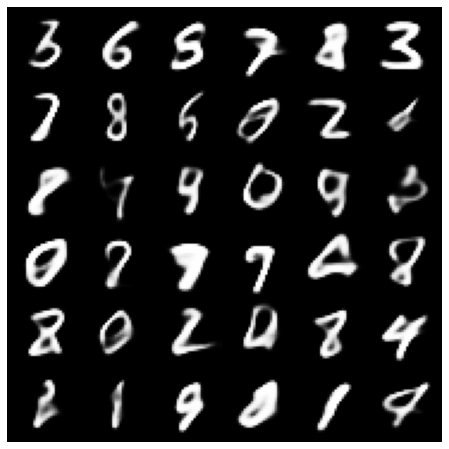

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

n = 6
z = torch.randn(n**2, z_dim)
x_rec = decoder(z.to(DEVICE))
ax.imshow(make_grid(x_rec.cpu(), nrow=n).permute(1, 2, 0).detach().numpy(), cmap="Greys")
ax.axis("off")

plt.show()

In [34]:
fig.savefig("iwae_mnist.png")

# NLL Estimation

In [21]:
K = 50
iw_sampler = IWAE(K=K, reduction="none")

In [22]:
results = []

encoder.train(False)
decoder.train(False)
for i, (X, _) in enumerate(loader_val):
    X = X.to(DEVICE)
    prior = EncoderPrior(X, encoder)
    posterior = DecoderPosterior(X, decoder)
    nll = -iw_sampler.elbo(prior, posterior)
    results.append(nll)
    print(f"\r[{i+1}/{len(loader_val)}] {nll.mean().item():.4f}\t\t\t",end="")
results = torch.cat(results).detach().cpu().numpy()

[4/4] 173.1577			

In [24]:
results.std()

160.22208

# HMC Steps

In [35]:
encoder = torch.load("encoder_iwae.torch")
decoder = torch.load("decoder_iwae.torch")
sampler = torch.load("sampler_hvae.torch")

In [97]:
inds = np.random.choice(range(BATCH_SIZE), 10, replace=False)
X = next(iter(loader_val))[0][inds].to(DEVICE)

encoder.train(False)
decoder.train(False)
prior = EncoderPrior(X, encoder)
posterior = DecoderPosterior(X, decoder)
sampler.verbose = True 
sampler.elbo(prior, posterior)
sampler.verbose = False

ratio = 2
img_steps = []
for step in sampler.hist[::ratio]:
    X_rec = decoder(step.to(DEVICE))
    img_steps.append(X_rec.detach().cpu())
img_steps = torch.stack(img_steps).transpose(0, 1).reshape(-1, 1, 28, 28)

[HIS] MC sample 0
[HIS] MC sample 1
[HIS] MC sample 2
[HIS] MC sample 3
[HIS] MC sample 4
[HIS] MC sample 5
[HIS] MC sample 6
[HIS] MC sample 7
[HIS] MC sample 8
[HIS] MC sample 9
[HIS] MC sample 10
[HIS] MC sample 11
[HIS] MC sample 12
[HIS] MC sample 13
[HIS] MC sample 14


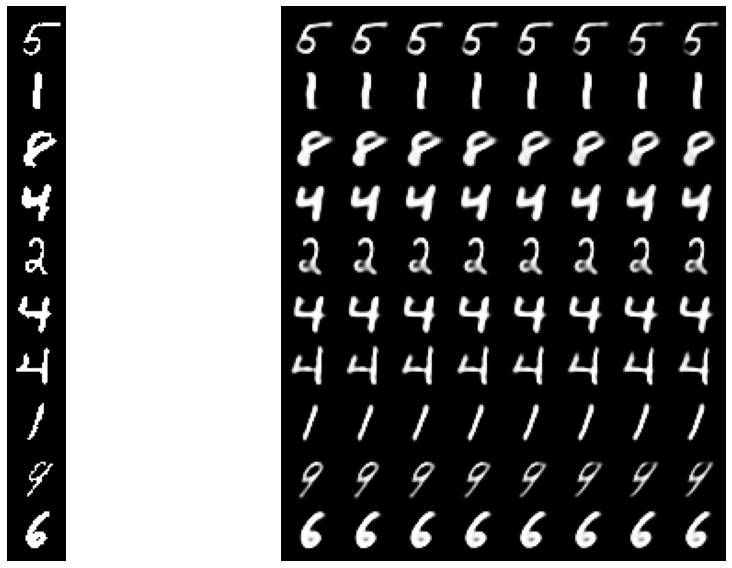

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

init_grid = make_grid(X.cpu(), nrow=1).permute(1, 2, 0).detach().numpy() 
ax[0].imshow(init_grid, cmap="Greys")
ax[0].axis("off")

ax[1].imshow(make_grid(img_steps, nrow=len(sampler.hist[::ratio])).permute(1, 2, 0).detach().numpy(), cmap="Greys")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [99]:
fig.savefig("hmc_iw_steps.png")

# Plots

In [100]:
import matplotlib.pyplot as plt
import jsoon

In [103]:
with open("losses_hvae.json", "r") as fd:
    losses_hvae = json.load(fd)
with open("losses_iwae.json", "r") as fd:
    losses_iwae = json.load(fd)

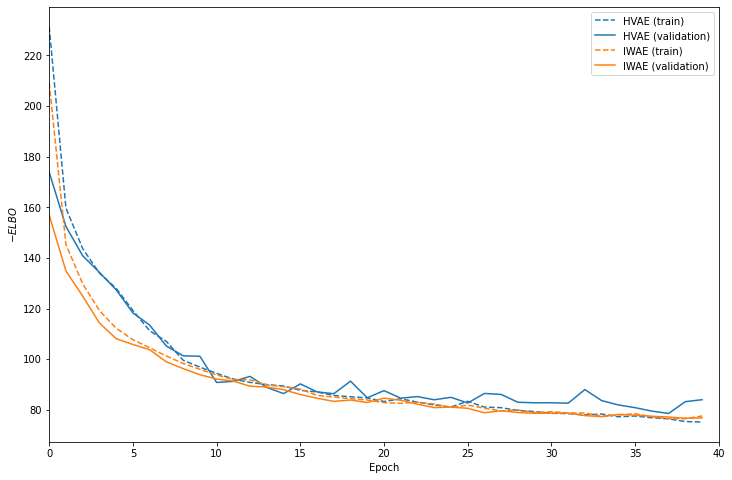

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(losses_hvae["train"], ls="--", c="C0", label="HVAE (train)")
ax.plot(losses_hvae["val"], ls="-", c="C0", label="HVAE (validation)")

ax.plot(losses_iwae["train"], ls="--", c="C1", label="IWAE (train)")
ax.plot(losses_iwae["val"], ls="-", c="C1", label="IWAE (validation)")

ax.set_xlim(0, 40)
ax.set_xlabel("Epoch")
ax.set_ylabel("$-ELBO$")
ax.legend()
plt.show()

In [120]:
fig.savefig("losses.png")